## Homework 8

## <em> Distributional Approximation and Gaussian Processes</em>
<br>
This notebook is arranged in cells. Texts are usually written in the markdown cells, and here you can use html tags (make it bold, italic, colored, etc). You can double click on this cell to see the formatting.<br>
<br>
The ellipsis (...) are provided where you are expected to write your solution but feel free to change the template (not over much) in case this style is not to your taste. <br>
<br>
<em>Hit "Shift-Enter" on a code cell to evaluate it.  Double click a Markdown cell to edit. </em><br>

***
### Link Okpy

In [ ]:
from client.api.notebook import Notebook
ok = Notebook('hw8.ok')
_ = ok.auth(inline = True)

### Imports

In [1]:
import numpy as np
from scipy.integrate import quad
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline

***

#### Problem - Back to Quasar

In HW5, we performed Principal Component Analysis (PCA) on the quasar (QSO) spectra from the Sloan Digital Sky Survey (SDSS); we filtered for high $S/N$ to apply the standard PCA and selected 18 high-$S/N$ spectra of QSOs with redshift 2.0 < z < 2.1, trimmed to $1340 < \lambda < 1620\ \mathring{A}$. Then, using the first three principal eigenvectors from the covariance matrix, we reconstructed each of the 18 QSO spectra.
<br><br>
In this assignment, we do Expectation Maximization PCA with and without per-observation weights. We use a simple noise fit of PCA components to individual spectra. Finally, using a Gaussian process, we compute the posterior distribution of the QSO's true emission spectrum and sample from it. 
<br><br>
The following analysis is based on https://arxiv.org/pdf/1208.4122.pdf, and https://arxiv.org/pdf/1605.04460.pdf
<br><br>

In [ ]:
# Load data
wavelength = np.loadtxt("HW5_Problem2_wavelength.txt")
X = np.loadtxt("HW5_Problem2_QSOspectra.txt")
ivar = np.loadtxt("HW5_Problem2_ivar_flux.txt")

In [ ]:
# Data dimension
print( np.shape(wavelength) )
print( np.shape(X) )
print( np.shape(ivar) )

In the above cell, we load the following data: wavelength in Angstroms ("wavelength"), a 2D array of spectra x fluxes ("$X$"), and another 2D array of inverse variances ($1/\sigma^2$) of the flux array ("ivar").
<br><br>
We have 824 wavelength bins, so "$X$" is a 18 $\times$ 824 matrix, each row containing fluxes of different QSO spectra and each column containing fluxes in different wavelength bins. (e.g. X[i,j] is the measured flux of QSO $i$ in wavelength bin $j$.) Similarly, "ivar" is a 18 $\times$ 824 matrix. (e.g. ivar[i,j] is the inverse variance of the flux of QSO $i$ in wavelength bin $j$.)
<br><br>
Remember that in HW5, we computed the eigenvectors of the covariance of the quasars, sorted by their descending eigenvalues; we call them the principal components (henceforth denoted by $\phi$). Suppose that we have $k$ eigenvectors, each of length 824. Construct the matrix of eigenvectors $\phi = [\phi_1\ \phi_2\ ...\ \phi_k]$, with $\phi_i$ the $i$th principal eigenvector.<br><br>
We can reconstruct the data as:<br><br>
$$ \hat{X} = \mu + \sum_k c_k \phi_k  $$
<br>
where $\mu$ is the mean of the initial dataset and $c_k$ is the reconstruction coefficient for eigenvector $\phi_k$.
<br><br>
More specifically, we define $\mu$ as:
<br><br>
$ \mu$ $ =
    \begin{bmatrix}
        \overline{x}_1 & \overline{x}_2 & \dots  &  \overline{x}_{824} \\
    \end{bmatrix}.$
<br><br>
The mean-centered data matrix $X_c$ can be defined as:
<br><br>
$X_c = X - \mu$ $ =
    \begin{bmatrix}
        x_{(1,1)} - \overline{x}_1 & x_{(1,2)} - \overline{x}_2 & \dots  & x_{(1,824)} - \overline{x}_{824} \\
        x_{(2,1)} - \overline{x}_1 & x_{(2,2)} - \overline{x}_2 & \dots  & x_{(2,824)} - \overline{x}_{824} \\
        \vdots & \vdots & \vdots & \vdots \\
        x_{(18,1)} - \overline{x}_1 & x_{(18,2)} - \overline{x}_2 & \dots  & x_{(18,824)} - \overline{x}_{824}
    \end{bmatrix}$
<br><br>
where $x_{m,n}$ denote the flux of $m$th QSO in $n$th wavelength bin, and $\overline{x}_k$ is the mean flux in $k$th wavelength bin.
<br><br>
$ \mu$ $ =
    \begin{bmatrix}
        \overline{x}_1 & \overline{x}_2 & \dots  &  \overline{x}_{824} \\
    \end{bmatrix}$
<br><br>
<span style="color:blue"> <i> 1. Plot $\mu$ as a function of wavelength $\lambda$.  </i></span> <br>

In [ ]:
...

<br><br>
"Expectation Maximization (EM) is an iterative technique for solving parameters to maximize a likelihood function for models with unknown hidden (or latent) variables. Each iteration involves two steps: finding the expectation value of the hidden variables given the current model (E-step), and then modifying the model parameters to maximize the fit likelihood given the estimates of the hidden variables (M-step)." (https://arxiv.org/pdf/1208.4122.pdf)
<br><br>
Now, do Expectation Maximization PCA. In this case, we wish to solve for the eigenvectors, and the latent variables are the coefficients $c$. The likelihood is "the ability of the eigenvectors to describe the data."
<br><br>
First, find the eigenvector $\phi_1$ with the highest eigenvalue (the first principal eigenvector):
<br><br>
1. Initialize: Let $\phi$ is a random vector of length 824.
<br><br>
2. <b>E-step</b>: For each QSO $j$, $$c_j = X_{row\ j} \cdot \phi$$ <br> Here, "$\cdot$" represents a dot product, so $X_{row\ j}$ and $\phi$ are vectors of length 824, so $c_j$ is a number. $c = [c_1\ c_2\ ...\ c_{18}]$ is a vector of length 18 (because we have 18 QSOs in this problem). So for each QSO $j$, we solve the coefficient $c_j$ which best fits that QSO using $\phi$.
<br><br>
3. <b>M-step</b>: $$\phi = \frac{\sum_j c_j\ X_{row\ j}}{\sum_j c_j^2} $$
<br>
Using the coefficients $c_j$, we update $\phi$ to find the vector which best fits the data given $c_j$.
<br><br>
4. Normalize: 
$$ \phi = \frac{\phi}{|\phi|} $$
<br><br>
5. Iterate until converged. Once converged, $c_1 = c$, and $\phi_1 = \phi$
<br><br>


After you get $\phi_1$, subtract the projection of $\phi$ from $X$ ($X - c_1 \otimes \phi_1$, where "$\otimes$" is the outer product (https://en.wikipedia.org/wiki/Outer_product). $c_1$ is a vector of length 18, and $\phi_1$ is a vector of length 824, so $c_1 \otimes \phi_1$ is a $18 \times 824$ matrix.) and repeat the EM algorithm.
<br><br>
(So to find $\phi_2$, you should use a data matrix $X - c \otimes \phi_1$. To find $\phi_2$, use $X - c_1 \otimes \phi_1 - c_2 \otimes \phi_2$), and so on.
<br><br>
<span style="color:blue"> <i> 2. Using EM PCA, find the first three principal eigenvectors $\phi_1, \phi_2, \phi_3$ and plot them as a function of wavelength.  </i></span> <br>

In [ ]:
...

Finally, reconstruct the data using the first principal eigenvectors:
<br><br>
$$ \hat{X} = \sum_{k = 1}^3 c_k \otimes \phi_k $$
<br>
<span style="color:blue"> <i> 3. For any one QSO spectra, plot the original and reconstructed spectra, using the above equation. </i></span> <br>

In [ ]:
...

Alternatively, you can also reconstruct the data using "PC scores." (Call the PC score matrix $Z$) 
<br><br>
$$ Z = X_c \phi $$
<br><br>
Then, we can reconstruct the data by mapping it back to 824 dimensions with $\bf \phi^T$:
<br><br>
$$ \hat{X} = \mu + Z \phi^T $$
<br>
<span style="color:blue"> <i> 4. For any one QSO spectra, plot the original and reconstructed spectra, using PC scores. </i></span> <br>

In [ ]:
...

Now, include noisier QSO spectra.

In [2]:
# Load data
wavelength = np.loadtxt("HW5_Problem2_wavelength_300.txt")
X = np.loadtxt("HW5_Problem2_QSOspectra_300.txt")
ivar = np.loadtxt("HW5_Problem2_ivar_flux_300.txt")

In [ ]:
ivar[ivar==0] = 1.e-4

In [3]:
# Data dimension
print( np.shape(wavelength) )
print( np.shape(X) )
print( np.shape(ivar) )

(824,)
(2562, 824)
(2562, 824)


We now have 2562 quasars (including 18 high $S/N$ quasars we had before). The below cell plots the spectra of two quasars; you can see how noisy they are.

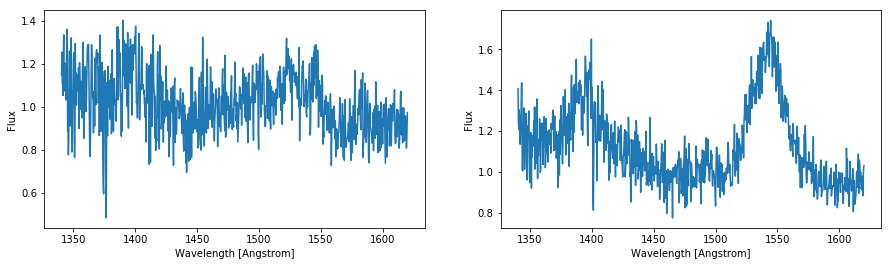

In [4]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
ax = axes[0]; i = 50
ax.plot(wavelength, X[i,:])
ax.set_xlabel('Wavelength [Angstrom]'); ax.set_ylabel('Flux')

ax = axes[1]; i = 500
plt.plot(wavelength, X[i,:])
ax.set_xlabel('Wavelength [Angstrom]'); ax.set_ylabel('Flux')
plt.show()

<br><br>
Now, perform EM PCA on 2562 quasars. 
<br><br>
<span style="color:blue"> <i> 5. Using EM PCA, find the first 10 principal eigenvectors $\phi_1, \phi_2, ..., \phi_{10}$ and reconstruct the data using them. ($ \hat{X} = \sum_{k = 1}^{10} c_k \otimes \phi_k $) For any two spectra, plot the original and reconstructed spectra. </i></span> <br>


In [ ]:
...

<br>
So far we treated all data equally when solving for the eigenvectors. However, we find that some data have considerably larger measurement noise, and they can unduly influence the solution. Now, we perform EM PCA with per-observation weights (called weighted EMPCA) so that the high $S/N$ data receive greater weight. (See https://arxiv.org/pdf/1208.4122.pdf for more detailed explanation. The following description is paraphrased from this paper.)
<br><br>
Basically, we add weights $w$ to the measured data in M-step: $\phi = \sum_j w_j\ c_j\ X_{row\ j}$
<br><br>
In this case, the situation is more complicated since the measured flux in each wavelength bin for each quasar has a different weight. So we cannot do a simple dot product to derive $c$; instead, we must solve a set of linear equations for $c$. Similarly, M-step must solve a set of linear equations to update $\phi$ instead of just performing a simple sum. Hence, the weighted EMPCA starts with a set of random orthonormal vectors and iterates over.
<br><br>
1. Initialize: Let $\phi$ is a set of random orthonormal vectors.

In [ ]:
# Create an aray of random orthonormal vectors
# Reference: https://github.com/sbailey/empca
def _random_orthonormal(nvec, nvar, seed=1):
    """
    Return array of random orthonormal vectors A[nvec, nvar] 
    Doesn't protect against rare duplicate vectors leading to 0s
    """

    if seed is not None:
        np.random.seed(seed)
        
    A = np.random.normal(size=(nvec, nvar))
    for i in range(nvec):
        A[i] /= np.linalg.norm(A[i])

    for i in range(1, nvec):
        for j in range(0, i):
            A[i] -= np.dot(A[j], A[i]) * A[j]
            A[i] /= np.linalg.norm(A[i])

    return A

# Number of quasars
nQSO = len(X)
# Number of wavelength bins
nLambda = len(wavelength)
# Number of eigenvectors we want
nEigvec = 10

# A set of random orthonormal vectors
phi = _random_orthonormal(nLambda, nEigvec, seed=1)

2. <b>E-step</b>: $X_{row\ j} = \phi\ c_{col\ j}$. ($X_{row\ j}$ refers to $j$th row of $X$, and $c_{col\ j}$ is $j$th column of $c$. Note that $X$ is a matrix of dimension "nQSO" x "nLambda", $\phi$ is a matrix of dimension "nLambda" x "nEigvec", and $c$ is a matrix of dimension "nEigvec" x "nQSO".) Solve for $c$ assuming weights $w$.
<br><br>
We define weight $w$ as the inverse variance ("ivar"). (So $w$ is a matrix of dimension "nQSO" x "nLambda") This makes sense. "We weight the measured data by the estimated measurement variance so that noisy observations do not unduly affect the solution, while allowing PCA to describe the remaining signal variance."
<br><br>
Now, solve $X_{row\ j} = \phi\ c_{col\ j}$ for $c_{col\ j}$ with weights $w_{row\ j}$. More generally, let $A = \phi, x = c_{col\ j}, b = X_{row\ j}, w = w_{row\ j}$:
<br><br>
$$ b = Ax $$<br>
$$ wb = wAx$$<br>
$$ A^T wb = (A^T w A)x$$<br>
$$ (A^T w A)^{-1}A^T wb = x$$<br>
<br><br>
Hence, we get:<br><br>
$$ c_{col\ j} = (\phi^T w_{row\ j}\ \phi)^{-1}\ \phi^T w_{row\ j}\ X_{row\ j} $$
<br><br>
In the below cell, we define the function "_solve." <br> _solve(A, b, w) solves $Ax = b$ with weights $w$. This function solves $Ax = b$ with weights $w$ using $x = (A^T w A)^{-1}A^T wb$

In [ ]:
# Solve Ax = b with weights w using the above set of equations
# Reference: https://github.com/sbailey/empca
import scipy
def _solve(A, b, w):
    """
    Solve Ax = b with weights w; return x
    
    A : 2D array
    b : 1D array length A.shape[0]
    w : 1D array same length as b
    """
  
    #- Apply weights
    # nvar = len(w)
    # W = dia_matrix((w, 0), shape=(nvar, nvar))
    # bx = A.T.dot( W.dot(b) )
    # Ax = A.T.dot( W.dot(A) )
    
    b = A.T.dot( w*b )
    A = A.T.dot( (A.T * w).T )

    if isinstance(A, scipy.sparse.spmatrix):
        x = scipy.sparse.linalg.spsolve(A, b)
    else:
        x = np.linalg.lstsq(A, b)[0]
        
    return x

Now, in the E-step, for each QSO $j$, we can solve $X_{row\ j} = \phi c_{col\ j}$ for $c_{col\ j}$ with weights $w_{row\ j}$ using the function "_solve".
<br><br>
Similarly in the M-step, for each wavelength bin $j$, we can solve $X_{col\ j} = c^T \phi_{row\ j}$ for $\phi_{row\ j}$ with weights $w_{col\ j}$ using the function "_solve".
<br><br>
<span style="color:blue"> <i> 6. The below cell uses the weighted EMPCA to find $\phi$. Fill in the blank and run the weighted EMPCA. </i></span> <br>

In [ ]:
C = np.zeros( (nEigvec, nQSO) )

W = ivar

# Number of iteration for EMPCA
niteration = 20

for jj in range(niteration):
    print("iteration", jj+1, "/20")
    
    # E-step
    for i in range(...):
        b = ...
        A = ...  
        w = ...           
        ... = _solve(A, b, w) 

    # M-step
    for j in range(nLambda):
        b = ...
        A = ...    
        w = ...
        ... = _solve(A, b, w)
        
        

<br><br>
Reconstruct the data using $\phi$:<br><br>
$$ \hat{X} = (\phi c)^T $$
<br><br>
$\phi$ is a matrix of dimension "nLambda" x "nEigvec", and $c$ is a matrix of dimension "nEigvec" x "nQSO". So $\hat{X}$ is a matrix of dimension "nQSO" x "nLambda" as expected.
<br><br>
<span style="color:blue"> <i> 7. Reconstruct the data using the above equation. Remember that you chose two spectra in Part 5. For the same two spectra, plot the original and reconstructed spectra. Part 5 uses EMPCA without weights. Compared to Part 5, does your reconstructed spectra become less noisy?    </i></span> <br>

In [ ]:
...

<br><br>
The following analysis is based on https://arxiv.org/pdf/1605.04460.pdf.
<br><br>
In Part 6, we reconstruct the QSO spectra from the noisy data. This reconstructed spectra is closer to the true spectra of QSO. Note that in reality, the true spectra can never be directly observed, both due to measurement error and due to absorption by intervening matter along the line of sight. So we wish to perform inference about the true spectra of QSO using a non-parametric technique called <b>Gaussian processes (GP)</b>. We henceforth call the measured spectra as $y(\lambda)$ and the true spectra as $f(\lambda)$ (where $\lambda$ refers to wavelength).
<br><br>
A gaussian process is fully specified by its first two central moments: a mean function $\mu(\lambda)$ and a covariance function $K(\lambda, \lambda')$: <br><br>
$$ \mu(\lambda) = \mathbb{E}[f(\lambda)\ \vert\ \lambda] $$<br>
$$ K(\lambda, \lambda') = \mathrm{cov}[f(\lambda), f(\lambda')\ \vert\ \lambda, \lambda'] $$.
<br>
In this problem, we can derive the posterior distribution of $f$ conditioned on the observed values of $y$: <br><br>
$$ p(f^*\ \vert\ \lambda^*, \lambda, y, \sigma(\lambda)^2) = \mathcal{N}(f^*\ \vert\ \mu_{f|y}(\lambda^*), K_{f|y}(\lambda^*, \lambda^{*,})) $$
<br>
where $\mathcal{N}(f\ \vert\ \mu, K)$ is a multivariate Gaussian given by: <br>
$$ \mathcal{N}(f\ \vert\ \mu, K) = \frac{1}{\sqrt{(2\pi)^d \mathrm{det}K}} \mathrm{exp}\big(-\frac{1}{2}(f-\mu)^TK^{-1}(f-\mu)\big) $$<br>
where $d$ is the dimension of $f$.
<br><br><br><br>
In other words, for the QSO $i$, the measured spectra $y$ is $X_{row\ i}$. Then, we can compute the posterior distribution of $f$ given $X_{row\ i}$ as:
<br><br>
$$ \mathcal{N}\big(f\ \big\vert\ \mu_{f|X_{row\ i}}, K_{f|X_{row\ i}}\big) $$
<br>
where $\mu$ is given by:
<br><br>
$ \mu$ $ =
    \begin{bmatrix}
        \overline{x}_1 & \overline{x}_2 & \dots  &  \overline{x}_{824} \\
    \end{bmatrix}.$
<br><br>
The mean function $\mu_{f|X_{row\ i}}$ and the covariance function $K_{f|X_{row\ i}}$ are defined as:<br><br>
$$ \mu_{f|X_{row\ i}} = \mu\ +\ K(K + V)^{-1}(X_{row\ i} - \mu)  $$<br>
$$ K_{f|X_{row\ i}} = K - K(K + V)^{-1}K$$
<br>
where $K = \phi \phi^T$ (We can use $\phi$ from Part 7. $\phi$ is a matrix of eigenvectors, its dimension is "nLambda" x "nEigvec"). <br><br>$V$ is a diagonal matrix whose entries are $\sigma(\lambda)^2$ e.g. for the QSO $i$, $V$ = np.diag(1/ivar[i,:]).
<br><br>
Finally, we can plot $f(\lambda)$ by sampling from $\mathcal{N}\big(f\ \big\vert\ \mu_{f|X_{row\ i}}, K_{f|X_{row\ i}}\big)$.
<br><br>
<span style="color:blue"> <i> 8. For any two spectra, plot $f(\lambda)$ using Gaussian processes. You can use np.random.multivariate_normal (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.multivariate_normal.html) to sample from a multivariate Gaussian. </i></span> <br>

In [ ]:
...

***

## To Submit
Execute the following cell to submit.
If you make changes, execute the cell again to resubmit the final copy of the notebook, they do not get updated automatically.<br>
__We recommend that all the above cells should be executed (their output visible) in the notebook at the time of submission.__ <br>
Only the final submission before the deadline will be graded. 


In [ ]:
_ = ok.submit()